# Strain mapping with py4DSTEM

The code in this directory calculates and visualizes strain maps.

The procedure is divided into 7 steps, each in a single notebook:
1. Get probe template
2. Get the Bragg disks
3. **Calibrate**
4. Calculate lattice vectors
5. Fit lattice vectors
6. Calculate strain
7. Visualize strain maps

# Notebook 3b: Calibrate elliptical distortions

In this step, we measure and correct elliptical distortion of the diffraction patterns. This step is useful to achieve the most accurate possible measurements, and may or may not be neccesary depending on the nature of the data, the scientific questions under study, and the analysis being performed.  Typical elliptical distortions are in the range of ~1-4%.

### Import packages, load data

In [27]:
import py4DSTEM

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Ellipse
from time import time
from scipy.ndimage.filters import gaussian_filter
from scipy.optimize import curve_fit

# i/o
from py4DSTEM.file.datastructure import DiffractionSlice, RealSlice, PointList
from py4DSTEM.file.io import FileBrowser, read, append

# Elliptical distortion correction
from py4DSTEM.process.utils import radial_integral, get_maxima_1D
from py4DSTEM.process.calibration import measure_elliptical_distortion, correct_elliptical_distortion, constrain_degenerate_ellipse
from py4DSTEM.process.braggdiskdetection import get_bragg_vector_map

In [3]:
# Examine file contents

fp_pr = "/home/ben/Data/20190302_calibrationData_Al_standards/NoBeamStop__from_20190307_LiFePO4_100percentLithiated/Al_STD_600mm_processing.h5"
browser = FileBrowser(fp_pr)
browser.show_dataobjects()

 Index                  Name                        Type        
   0    datacube                            DataCube            
   1    braggvectormap_shiftcorrected       DiffractionSlice    
   2    braggvectormap_shiftcorrected_ellipsecorrectedDiffractionSlice    
   3    braggvectormap_uncorrected          DiffractionSlice    
   4    probe                               DiffractionSlice    
   5    diffraction_shifts                  RealSlice           
   6    elliptical_distortion               PointList           
   7    braggpeaks                          PointListArray      
   8    braggpeaks_shiftcorrected           PointListArray      
   9    braggpeaks_shiftcorrected_ellipticalcorrectedPointListArray      


In [4]:
# Load data

braggpeaks_shiftcorrected = browser.get_dataobject('braggpeaks_shiftcorrected')
braggvectormap_shiftcorrected = browser.get_dataobject('braggvectormap_shiftcorrected').data2D
browser.close()

In [5]:
R_Nx,R_Ny = braggpeaks_shiftcorrected.shape
Q_Nx,Q_Ny = braggvectormap_shiftcorrected.shape

### 2. Elliptical distortion

Here we measure and correct elliptical distortion of the diffraction patterns due to imperfect electron optics.  We proceed as follows:

- Fit an initial ellipse to an annular region of the Bragg vector map
- Constrain the resulting degenerate ellipse using a known angle between the fitting Bragg peaks
- Correct the elliptical distortions
- Measure final, corrected elliptical distortions

More details are found in notebooks/module_demos/calibration/ellipticaldistortion.ipynb and notebooks/module_demos/calibration/ellipticaldistortion_crystalline.ipynb.

#### Fit initial ellipse

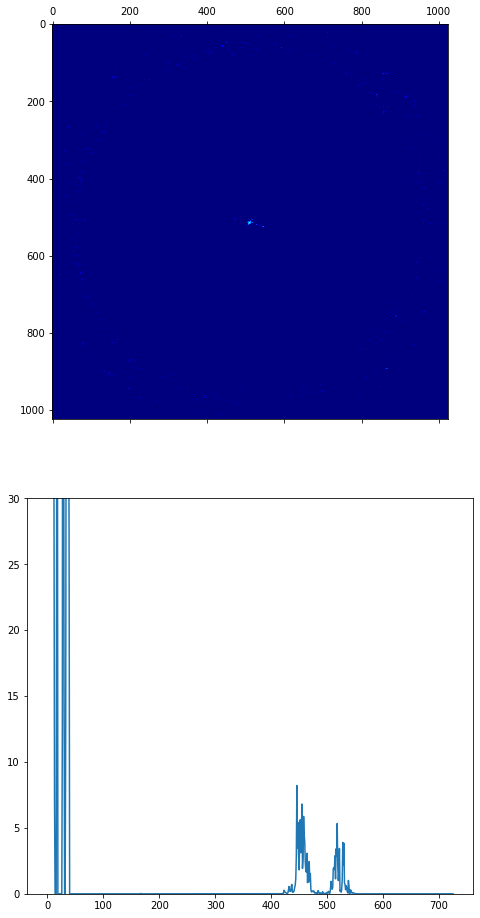

In [6]:
# Show Bragg vector map, calculate radial integral

ymax=30
power=0.25

x0,y0 = np.unravel_index(np.argmax(gaussian_filter(braggvectormap_shiftcorrected,2)),(Q_Nx,Q_Ny))
radial_profile = radial_integral(braggvectormap_shiftcorrected,x0,y0)[0]

fig,(ax1,ax2) = plt.subplots(2,1,figsize=(8,16))
ax1.matshow(braggvectormap_shiftcorrected**power,cmap='jet')
ax2.plot(np.arange(len(radial_profile)),radial_profile)
ax2.set_ylim(0,ymax)
plt.show()

In [1]:
# Specify annular fitting region
# Get annulus center from selected radial profile maximum, specify annulus width

##### Parameters #####
# Find maxima
sigma = 3
minSpacing = 10
minRelativeIntensity = 0.01
relativeToPeak = 1

# Select a maximum and annulus width
selected_index = 2
annulus_width = 48

# Display params
text_offset = 5
power = 0.25
#######################

maxima = get_maxima_1D(radial_profile, sigma=sigma, minSpacing=minSpacing,
                       minRelativeIntensity=minRelativeIntensity,
                       relativeToPeak=relativeToPeak)

r_peak = maxima[selected_index]
r_inner = r_peak - annulus_width/2.
r_outer = r_peak + annulus_width/2.

# Show
profile_smoothed = gaussian_filter(radial_profile,sigma)
fig,(ax2,ax1) = plt.subplots(2,1,figsize=(8,16))
ax1.plot(np.arange(len(profile_smoothed)),profile_smoothed)
ax1.scatter(maxima,profile_smoothed[maxima],color='r')
for i in range(len(maxima)):
    if profile_smoothed[maxima[i]] < ymax:
        ax1.text(maxima[i]+text_offset,profile_smoothed[maxima[i]],'{}'.format(i))
ax1.scatter(r_peak,profile_smoothed[r_peak],color='yellow')
ax1.vlines((r_inner,r_outer),0,ax1.get_ylim()[1],linestyle=":")
ax1.set_ylim(0,ymax)

ax2.matshow(braggvectormap_shiftcorrected**power,cmap='jet')
circle_inner = Circle((y0,x0),radius=r_inner, fill=False, edgecolor='r', linestyle="-")
circle_outer = Circle((y0,x0),radius=r_outer, fill=False, edgecolor='r', linestyle="-")
ax2.add_patch(circle_inner)
ax2.add_patch(circle_outer)

plt.show()

NameError: name 'get_maxima_1D' is not defined

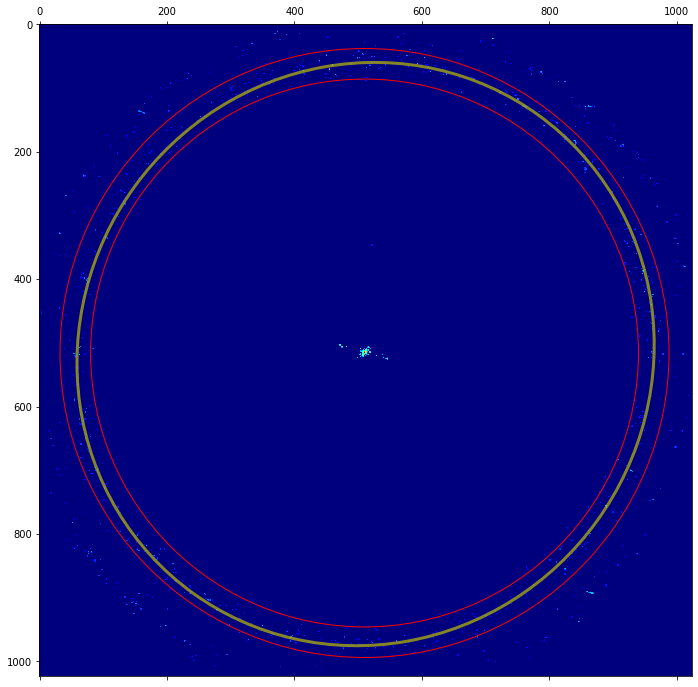

Measured ellipticity = 3.3654340038623998%
Measured theta = -35.856228402099795 degrees


In [8]:
# Measure elliptical distortion

power = 0.15

# Measure with no mask
ellipse_params,_ = measure_elliptical_distortion(braggvectormap_shiftcorrected, x0, y0, r_inner, r_outer)
x,y,a,b,theta = ellipse_params

# Show
fig,ax=plt.subplots(figsize=(12,12))
ax.matshow(braggvectormap_shiftcorrected**power,cmap='jet')
circle_inner = Circle((y0,x0),radius=r_inner, fill=False,edgecolor='r',linestyle="-")
circle_outer = Circle((y0,x0),radius=r_outer, fill=False,edgecolor='r',linestyle="-")
ellipse = Ellipse((y,x),2*a,2*b,90-np.degrees(theta), fill=False,edgecolor='y',linestyle="-",linewidth=3, alpha=.7)
ax.add_patch(circle_inner)
ax.add_patch(circle_outer)
ax.add_patch(ellipse)
plt.show()

print("Measured ellipticity = {}%".format(100*(max(a,b)/min(a,b)-1)))
print("Measured theta = {} degrees".format(np.degrees(theta)))

#### Correct elliptical distortions

In [9]:
corrected_ellipse_params = [x,y,a,b,theta]
braggpeaks_ellipsecorrected = correct_elliptical_distortion(braggpeaks_shiftcorrected, corrected_ellipse_params)

#### Measure corrected elliptical distortions

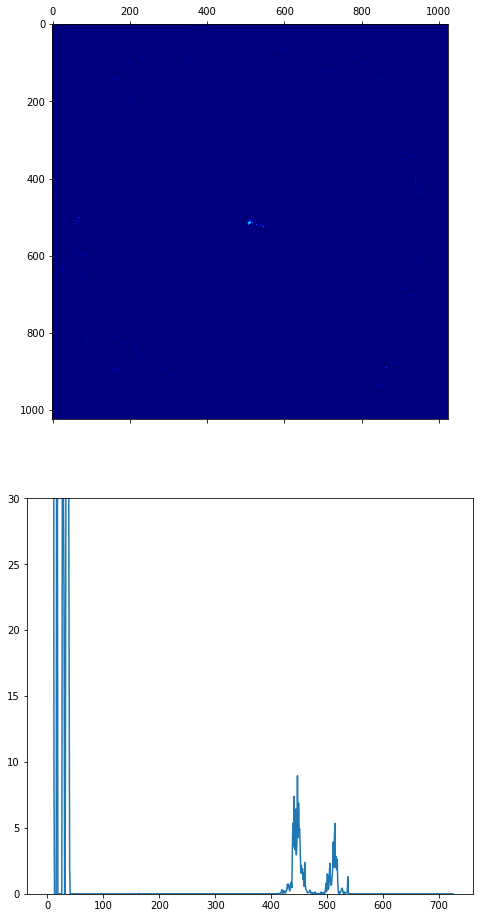

In [10]:
# Get new Bragg vector map and radial integral

power=0.25

braggvectormap_ellipsecorrected = get_bragg_vector_map(braggpeaks_ellipsecorrected,Q_Nx,Q_Ny)
x0,y0 = np.unravel_index(np.argmax(gaussian_filter(braggvectormap_ellipsecorrected,2)),(Q_Nx,Q_Ny))
radial_profile = radial_integral(braggvectormap_ellipsecorrected,x0,y0)[0]

fig,(ax1,ax2) = plt.subplots(2,1,figsize=(8,16))
ax1.matshow(braggvectormap_ellipsecorrected**power,cmap='jet')
ax2.plot(np.arange(len(radial_profile)),radial_profile)
ax2.set_ylim(0,ymax)
plt.show()

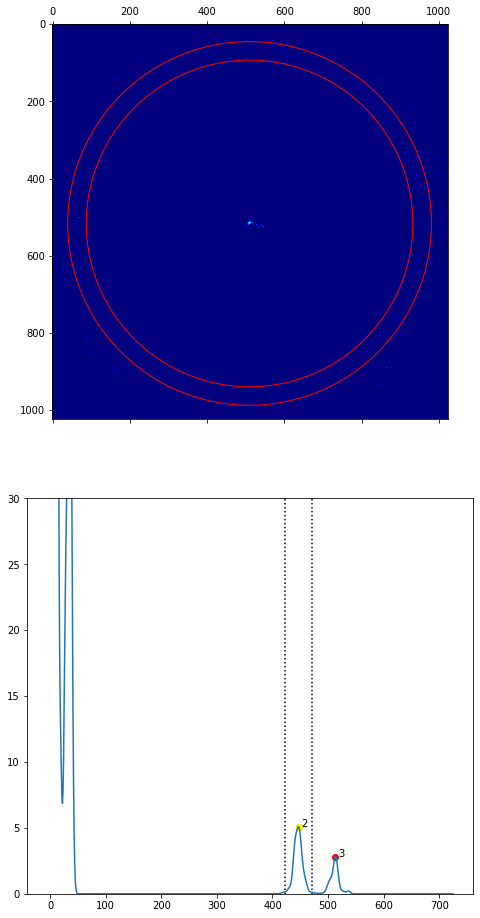

In [11]:
# Get radial profile maxima, and select one

##### Parameters #####
# Find maxima
sigma = 3
minSpacing = 10
minRelativeIntensity = 0.01
relativeToPeak = 1

# Select a maximum
selected_index = 2
annulus_width = 48

# Display params
text_offset = 5
power = 0.25
#######################

maxima = get_maxima_1D(radial_profile, sigma=sigma, minSpacing=minSpacing,
                       minRelativeIntensity=minRelativeIntensity,
                       relativeToPeak=relativeToPeak)

r_peak = maxima[selected_index]
r_inner = r_peak - annulus_width/2.
r_outer = r_peak + annulus_width/2.

# Show
profile_smoothed = gaussian_filter(radial_profile,sigma)
fig,(ax2,ax1) = plt.subplots(2,1,figsize=(8,16))
ax1.plot(np.arange(len(profile_smoothed)),profile_smoothed)
ax1.scatter(maxima,profile_smoothed[maxima],color='r')
for i in range(len(maxima)):
    if profile_smoothed[maxima[i]] < ymax:
        ax1.text(maxima[i]+text_offset,profile_smoothed[maxima[i]],'{}'.format(i))
ax1.scatter(r_peak,profile_smoothed[r_peak],color='yellow')
ax1.vlines((r_inner,r_outer),0,ax1.get_ylim()[1],linestyle=":")
ax1.set_ylim(0,ymax)

ax2.matshow(braggvectormap_ellipsecorrected**power,cmap='jet')
circle_inner = Circle((y0,x0),radius=r_inner, fill=False, edgecolor='r', linestyle="-")
circle_outer = Circle((y0,x0),radius=r_outer, fill=False, edgecolor='r', linestyle="-")
ax2.add_patch(circle_inner)
ax2.add_patch(circle_outer)

plt.show()

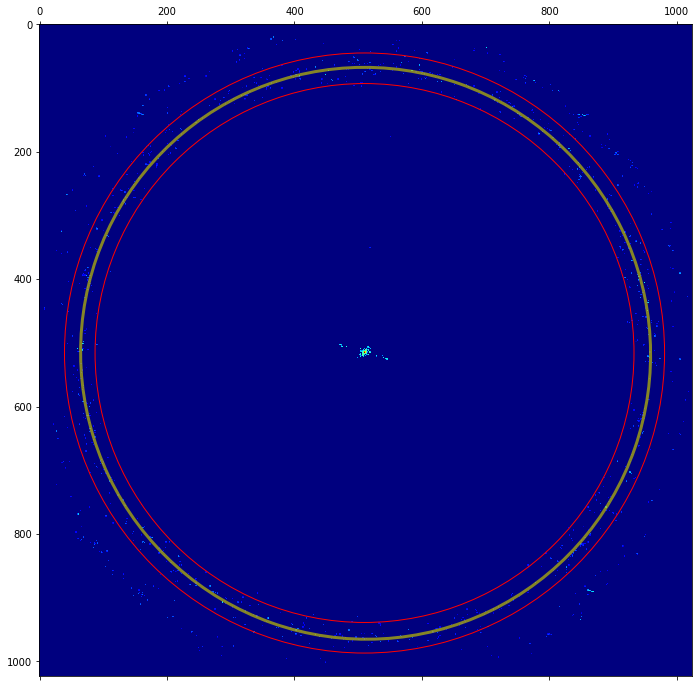

Measured ellipticity = 0.5314159996325563%


In [12]:
# Measure elliptical distortion

power = 0.15

# Measure with no mask
ellipse_params,_ = measure_elliptical_distortion(braggvectormap_ellipsecorrected, x0, y0, r_inner, r_outer)
x_c,y_c,a_c,b_c,theta_c = ellipse_params

# Show
fig,ax=plt.subplots(figsize=(12,12))
ax.matshow(braggvectormap_ellipsecorrected**power,cmap='jet')
circle_inner = Circle((y0,x0),radius=r_inner, fill=False,edgecolor='r',linestyle="-")
circle_outer = Circle((y0,x0),radius=r_outer, fill=False,edgecolor='r',linestyle="-")
ellipse = Ellipse((y_c,x_c),2*a_c,2*b_c,90-np.degrees(theta_c), fill=False,edgecolor='y',linestyle="-",linewidth=3, alpha=.7)
ax.add_patch(circle_inner)
ax.add_patch(circle_outer)
ax.add_patch(ellipse)
plt.show()

print("Measured ellipticity = {}%".format(100*(max(a_c,b_c)/min(a_c,b_c)-1)))

### Measure Q pixel size

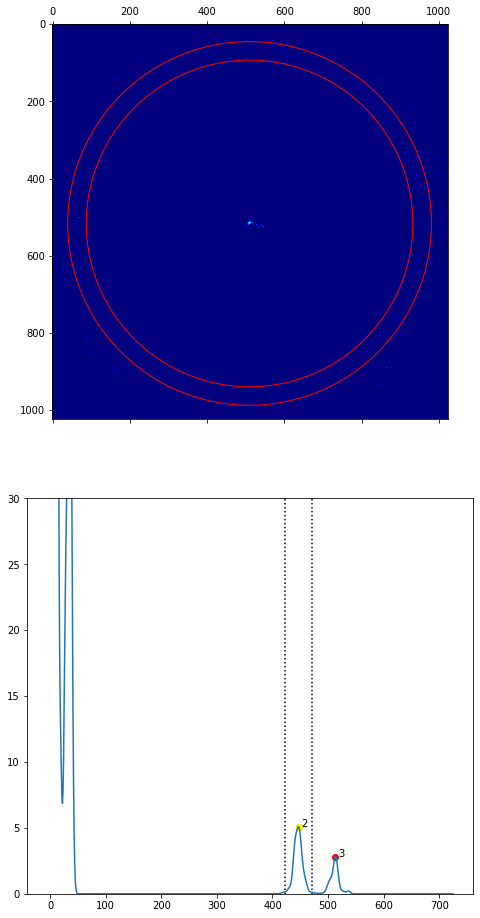

In [13]:
# Get radial profile maxima, and select one

##### Parameters #####
# Find maxima
sigma = 3
minSpacing = 10
minRelativeIntensity = 0.01
relativeToPeak = 1

# Select a maximum
selected_index = 2
annulus_width = 48

# Display params
text_offset = 5
power = 0.25
#######################

maxima = get_maxima_1D(radial_profile, sigma=sigma, minSpacing=minSpacing,
                       minRelativeIntensity=minRelativeIntensity,
                       relativeToPeak=relativeToPeak)

r_peak = maxima[selected_index]
r_inner = r_peak - annulus_width/2.
r_outer = r_peak + annulus_width/2.

# Show
profile_smoothed = gaussian_filter(radial_profile,sigma)
fig,(ax2,ax1) = plt.subplots(2,1,figsize=(8,16))
ax1.plot(np.arange(len(profile_smoothed)),profile_smoothed)
ax1.scatter(maxima,profile_smoothed[maxima],color='r')
for i in range(len(maxima)):
    if profile_smoothed[maxima[i]] < ymax:
        ax1.text(maxima[i]+text_offset,profile_smoothed[maxima[i]],'{}'.format(i))
ax1.scatter(r_peak,profile_smoothed[r_peak],color='yellow')
ax1.vlines((r_inner,r_outer),0,ax1.get_ylim()[1],linestyle=":")
ax1.set_ylim(0,ymax)

ax2.matshow(braggvectormap_ellipsecorrected**power,cmap='jet')
circle_inner = Circle((y0,x0),radius=r_inner, fill=False, edgecolor='r', linestyle="-")
circle_outer = Circle((y0,x0),radius=r_outer, fill=False, edgecolor='r', linestyle="-")
ax2.add_patch(circle_inner)
ax2.add_patch(circle_outer)

plt.show()

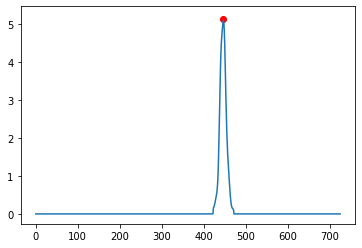

In [58]:
# Fit a gaussian to find peak spacing

mask = (r_inner<=np.arange(len(profile_smoothed))) * (r_outer>=np.arange(len(profile_smoothed)))
data = profile_smoothed * mask

gaussian = lambda x, A, mu,sigma: A*np.exp(-0.5*((x-mu)/sigma)**2)
xmin = np.min(np.nonzero(mask)[0])
xwidth = sum(mask)
data_xvals = np.arange(xwidth)
data_yvals = profile_smoothed[xmin:xmin+xwidth]
popt_guess = [np.max(data_yvals),np.argmax(data_yvals),(r_outer-r_inner)/4.]
popt,_ = curve_fit(gaussian,data_xvals,data_yvals,popt_guess)
mu = xmin+popt[1]

fig,ax = plt.subplots()
ax.plot(np.arange(len(data)),data)
ax.scatter(mu,popt[0],color='r')
plt.show()

In [59]:
# Get pixel calibration

d_spacing_A = 2.338     # from TedPella product description - Diffraction Standard Evaporated Aluminum, prod. no. 619
inv_A_per_pixel = 1./(d_spacing_A * mu)

### Add metadata

In [12]:
# Hacky - use pointlists for now. Roll into Metadata objects later.

coords = [('x',float),('y',float),('a',float),('b',float),('theta',float)]
elliptical_distortion_params = PointList(coordinates=coords)
elliptical_distortion_params.name = 'elliptical_distortion'
elliptical_distortion_params.add_point((x,y,a,b,theta))

In [82]:
coords = [('inv_A_per_pixel',float)]
Qpix_calibration = PointList(coordinates=coords)
Qpix_calibration.add_point((inv_A_per_pixel,))
Qpix_calibration.name = "Qpixel_calibration"

### Save

In [13]:
# Store relevant data in  DataObjects

# Corrected Bragg vector map
braggvectormap_corrected_diffslice = DiffractionSlice(braggvectormap_ellipsecorrected, name='braggvectormap_shiftcorrected_ellipsecorrected')

In [14]:
# Append to processing file

dataobjects = [braggvectormap_corrected_diffslice, braggpeaks_ellipsecorrected, elliptical_distortion_params,Qpix_calibration]

append(dataobjects, fp_pr)

Opening file /home/ben/Data/20190302_calibrationData_Al_standards/NoBeamStop__from_20190307_LiFePO4_100percentLithiated/Al_STD_600mm_processing.h5...
Done.
